### Extracting data

In [28]:
import numpy as np
import pandas as pd


LEFT = 1
RIGHT = 2

# It must not be greater than the number of downloaded files
SESSIONS_TO_LOAD = 6

# Order: none, left, right ... 4 seconds cue, 2 seconds pause
# One trial was 18
# Left starts at + 7 sec
# Rigt starts at + 13
# eeg is of (channels,samples)
def get_trials(eeg, sfreq=1000, trial_len=4, n_epochs=10, n_channels=3):
    t = 1/sfreq
    n_time_samples = trial_len * sfreq
    direction = 2
    X = np.zeros((n_epochs, n_channels, n_time_samples))
    y = []
    i = 0
    # 6000 - 180000
    # 240000 - 320000
    for epoch in range(0,n_epochs,2):
        left_start_sample = (epoch*18 + 6) * sfreq
        left_end_sample = left_start_sample + 4*sfreq
        right_start_sample = (epoch*18 + 12) * sfreq
        right_end_sample = right_start_sample + 4*sfreq
        X[epoch,] = eeg[:,left_start_sample:left_end_sample]
        X[epoch+1,] = eeg[:,right_start_sample:right_end_sample]
        y.append(LEFT)
        y.append(RIGHT)
        
#     for pos, eve, dur in labels:
#         if eve == TRIAL_START:
#             start = int(pos/t)
#             X[i,] = eeg[:, start:start + n_time_samples]
#             i += 1


    return X, np.array(y)

channel_names = ["C3", "C4", "Cz"]

channel_index = [1, 3, 2]

X, y = [], []

# Loading eeg signals and extracting motor imagery trials
signal = np.loadtxt("OpenBCI-RAW-2020-02-16_17-06-05_eyes_closed.txt", delimiter=",", skiprows=6, usecols=channel_index) #(n_time_samples,n_channels)
X, y = get_trials(signal.T) # (n_epochs, n_channels, n_time_samples)


# X = np.concatenate(tuple(X))
# y = np.concatenate(tuple(y))

pd.options.display.float_format = "{:.2f}".format
trials = pd.DataFrame(np.hstack(tuple(X)).T, columns=channel_names)


print("%s trials loaded, %s channels and %s time samples per trial" % X.shape)
print("Statistics about the signals grouped by channel for left trials:")
print(trials.describe())
print(y.shape)

10 trials loaded, 3 channels and 4000 time samples per trial
Statistics about the signals grouped by channel for left trials:
            C3        C4        Cz
count 40000.00  40000.00  40000.00
mean   6094.05 -40518.09 -32241.83
std     559.41    180.22    206.33
min    5137.28 -40859.75 -32629.63
25%    5555.10 -40697.70 -32420.60
50%    6115.85 -40507.83 -32267.09
75%    6583.89 -40341.32 -32062.21
max    7053.67 -40154.39 -31767.91
(10,)


### Pre-processing
Now, we are going to standardize our data using the standard score statistical measure (more commonly referred to as z-score) and resample the signals at 256 Hz.


In [29]:
from scipy.signal import resample
from scipy.stats import zscore

trial_len = 4  # trial length in seconds
new_sfreq = 256  # new sampling frequency
n_time_samples = trial_len * new_sfreq

# Standardizing and resampling signals
X_resampled = resample(zscore(X, axis=2), n_time_samples, axis=2)

trials = pd.DataFrame(np.hstack(tuple(X_resampled)).T, columns=channel_names)

print("Signals resampled at %s Hz" % new_sfreq)
print("Statistics about the signals grouped by channel:")
print(trials.describe())

Signals resampled at 256 Hz
Statistics about the signals grouped by channel:
            C3       C4       Cz
count 10240.00 10240.00 10240.00
mean     -0.00     0.00     0.00
std       1.00     0.99     1.00
min      -2.55    -3.31    -2.85
25%      -0.83    -0.71    -0.79
50%       0.20     0.07     0.16
75%       0.75     0.72     0.75
max       2.15     3.43     2.52


To train and test our machine learning model, we need to divide our data in two sets with the following sizes:

Training set: it will be the half of the data. It will be used for cross-validation and training.
Test set: it will be the remaining half of the data.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled,
                                                    y,
                    						        test_size=.5,
                        						    random_state=7, 
                        						    stratify=y)

print("Data set size: %d trials (100%%)" % (y.size))
print("Training set size: %d trials (%d%%)" % (y_train.size, y_train.size/y.size*100))
print("Test set size: %d trials (%d%%)" % (y_test.size, y_test.size/y.size*100))

Data set size: 10 trials (100%)
Training set size: 5 trials (50%)
Test set size: 5 trials (50%)


### Averaging and plotting motor imagery trials

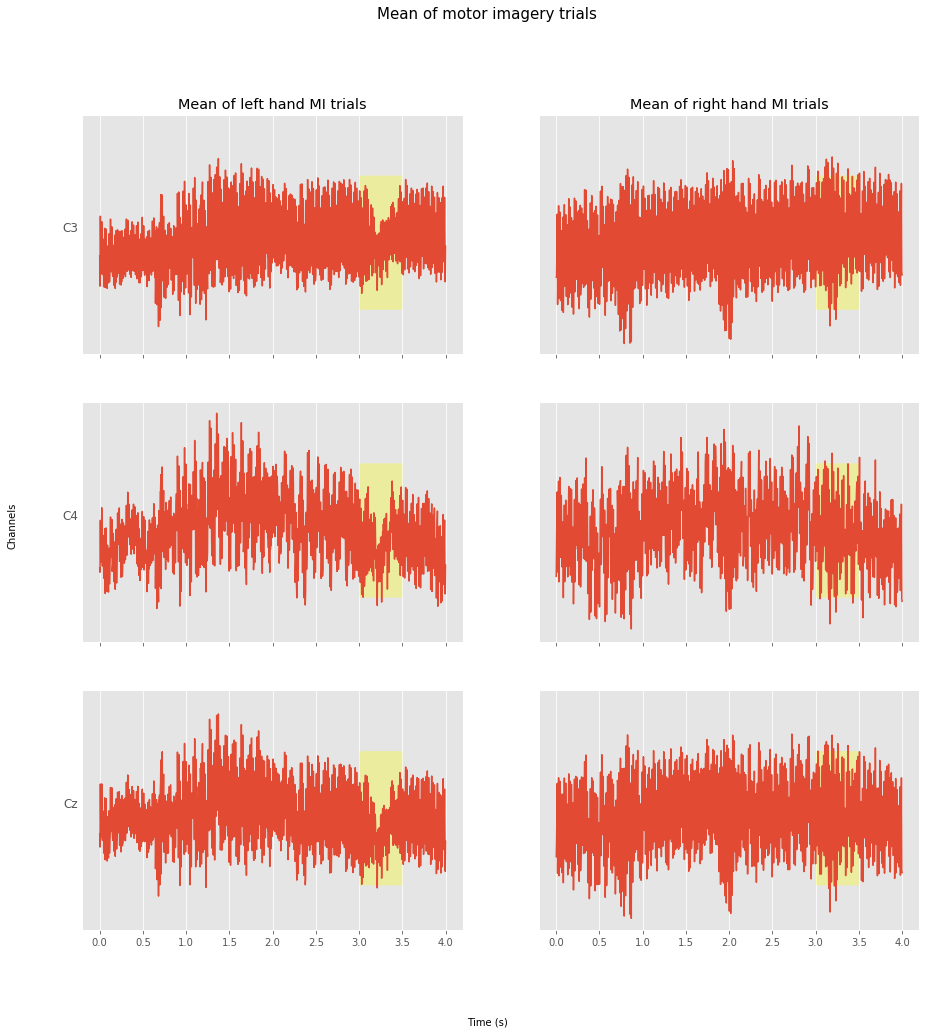

In [31]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

def plot_trials(X, y, channel_names, title, sfreq=256, trial_len=4):
    X_left = np.mean(X[y == LEFT,], 0) # Left epochs (n_channels,n_time_samples)
    X_right = np.mean(X[y == RIGHT,], 0) # Right epochs
    n_time_samples = sfreq * trial_len
    x = np.linspace(0, trial_len, n_time_samples)
    xf = np.linspace(3.5, trial_len-1, n_time_samples)
    n_channels = len(channel_names)
    fig, axarr = plt.subplots(n_channels, 2, sharex=True, sharey=True,figsize=(15,15))
    fig.suptitle(title, fontsize=15)
    # For every channel
    for ax, left, right, lbl in zip(axarr, X_left, X_right, channel_names):
        ax[0].fill_between(xf, -1, 1, facecolor="yellow", alpha=0.3) #highlight (-1,-1) since we standardized our data
        ax[1].fill_between(xf, -1, 1, facecolor="yellow", alpha=0.3)
        ax[0].set_ylabel(lbl, ha="right", rotation="horizontal")
        ax[0].plot(x, left)
        ax[1].plot(x, right)
        ax[0].yaxis.set_major_locator(plt.NullLocator())
        ax[1].yaxis.set_major_locator(plt.NullLocator())
        plt.setp(ax[0].get_yticklabels(), visible=False)
        plt.setp(ax[1].get_yticklabels(), visible=False)
        
    axarr[0,0].set_title("Mean of left hand MI trials")
    axarr[0,1].set_title("Mean of right hand MI trials")
    
    fig.text(0.06, 0.5, "Channels", ha="center", va="center", rotation="vertical")
    fig.text(0.5, 0.04, "Time (s)", ha="center", va="center", rotation="horizontal")
    #plt.show(plt, width="800px")
#X[[1,2,6,9]]
plot_trials(X_train, y_train, channel_names, "Mean of motor imagery trials")

### Feature extraction
This stage is essential and probably the most important in all machine learning approaches, because a good classifier is useless without good features. To extract the features, we are going to use a bank of band-pass filters, namely 6 - 10 Hz, 8 - 12 Hz, 10 - 14 Hz, …, 28 - 32 Hz, and then apply the Common Spatial Pattern (CSP) method on each set of filtered EEG signals. CSP is a spatial filter that allows reducing the number of EEG channels by selecting those which have maximum differences in variance. Each pair of band-pass and CSP filters computes the CSP features, which are specific to the band-pass frequency range.

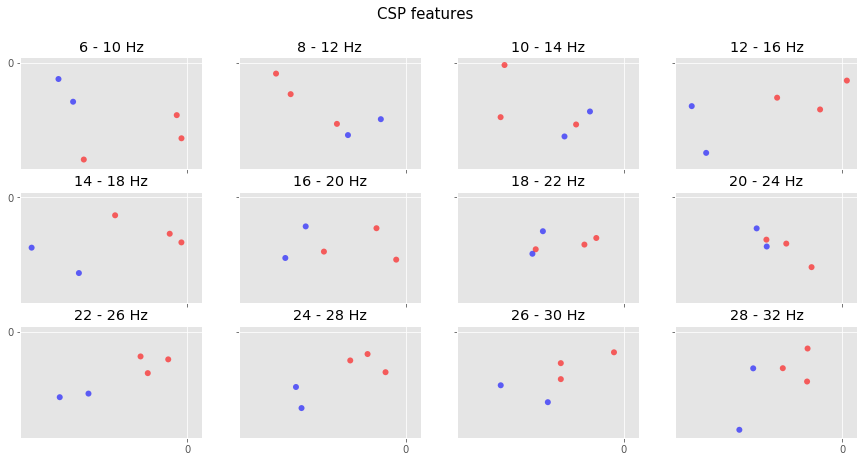

In [32]:
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MultipleLocator
from mne.decoding import CSP
from scipy.signal import filtfilt, iirdesign, resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion


class BandPassFilter(BaseEstimator, TransformerMixin):
    
    def __init__(self, low_freq=7., high_freq=30., gpass=0.5, gstop=10.,
                 sfreq=250., ftype='cheby2'):
        nyquist = sfreq / 2.
        wp = [low_freq / nyquist, high_freq / nyquist]
        ws = [(low_freq - 0.5) / nyquist, (high_freq + 0.5) / nyquist]
        self.b, self.a = iirdesign(wp, ws, gpass, gstop, ftype=ftype)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return filtfilt(self.b, self.a, X)

# output is of shape (n_epochs,n_filters*n_csp_component) because we have "n_filters" different frequency bands
# and for each we have n_csp_component values in the array
def create_fbcsp(low_freq, n_filters=12, band_overlap=2,
                 band_width=4, n_csp_components=2, n_jobs=1):
    pipeline_list = []
    step = band_width - band_overlap
    bands = range(low_freq, low_freq + n_filters * step, step)
    for low in bands:
        pipeline_list.append(
            ("pipe%d" % low, Pipeline([
                ("filter", BandPassFilter(low, low + band_width)),
                ("csp", CSP(n_components=n_csp_components))
            ]))
        )
    
    return FeatureUnion(pipeline_list, n_jobs=n_jobs)

cm_bright = ListedColormap(["#FF0000", "#0000FF"])
majorLocator = MultipleLocator(2)

def plot_features(X, y, bands, band_width=4):
    n_feats = X.shape[1]
    fig, axarr = plt.subplots(3, int(n_feats/6), sharex=True, sharey=True, figsize=(15,7))
    flat = axarr.reshape(int(n_feats/2))
    
    for ax, low, i in zip(flat, bands, range(0, n_feats, 2)):
        ax.scatter(X[:,i], X[:,i+1], c=y, edgecolor="", alpha=0.6, cmap=cm_bright) # PLot the CSP features f1,f2 for X
        ax.set_title("%d - %d Hz" % (low, low + band_width))
        ax.xaxis.set_major_locator(majorLocator)
        ax.yaxis.set_major_locator(majorLocator)
    
    fig.suptitle("CSP features", fontsize=15)

bands = range(6, 29, 2)
fbcsp = create_fbcsp(6, n_jobs=2) # create the estimator
X_train_feats = fbcsp.fit_transform(X_train, y_train) # run the estimator
plot_features(X_train_feats, y_train, bands)

In [33]:
print(y_train.shape)
X_train_feats[:,1].shape

(5,)


(5,)

### Feature selection
(Need to automate in the future)

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

i_feats = range(0, 23, 2)
clf = SVC(kernel="linear")

for i, low in zip(i_feats, bands):
    n_feat = [i, i+1]
    score = cross_val_score(clf, X_train_feats[:,n_feat], y_train) # Use cross validation to try out different subsets of points
    print("Classification accuracy for frequency band %d - %d: %.2f" 
          % (low, low+4, score.mean()))

Classification accuracy for frequency band 6 - 10: 0.50
Classification accuracy for frequency band 8 - 12: 0.67
Classification accuracy for frequency band 10 - 14: 0.67
Classification accuracy for frequency band 12 - 16: 0.83
Classification accuracy for frequency band 14 - 18: 0.67
Classification accuracy for frequency band 16 - 20: 0.33
Classification accuracy for frequency band 18 - 22: 0.33
Classification accuracy for frequency band 20 - 24: 0.33
Classification accuracy for frequency band 22 - 26: 0.67
Classification accuracy for frequency band 24 - 28: 0.67
Classification accuracy for frequency band 26 - 30: 0.67
Classification accuracy for frequency band 28 - 32: 0.67


c:\users\michael karras\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\michael karras\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\michael karras\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\michael karras\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selecti

Text(0.5,0.98,'Selected features from band 12 - 16 Hz')

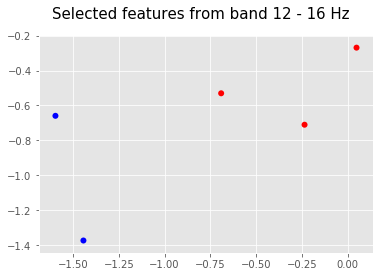

In [35]:
def plot_selected_features(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="", cmap=cm_bright)

plot_selected_features(X_train_feats[:, [6, 7]], y_train)
plt.suptitle("Selected features from band 12 - 16 Hz", fontsize=15)

The cerebral activity is different among people, so we cannot generalize that this frequency band will always contain the best features to classify this type of signals for all people. Obviously, there are more sophisticated and complicated feature extraction methods, but for reasons of simplicity, we are going to use this method. The code below allows to create an object to be added to our pipeline for feature selection stage.



In [36]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    # Update to automatically select features
    def transform(self, X, y=None):
        return X[:,self.features]


### Classification
Our classifier will be a Support Vector Machine (SVM). In this stage, it will be constructed a pipeline that will perform all the four stages of our model to classify motor imagery EEG signals. After training the model, we will plot the decision boundary of the SVM.

In [37]:
svc = SVC(kernel="linear")

clf = Pipeline([
    ("fbcsp", fbcsp),
    ("fselector", FeatureSelector(features=[6, 7])),
    ("classifier", svc)
])

clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('fbcsp',
                 FeatureUnion(n_jobs=2,
                              transformer_list=[('pipe6',
                                                 Pipeline(memory=None,
                                                          steps=[('filter',
                                                                  BandPassFilter(ftype=None,
                                                                                 gpass=None,
                                                                                 gstop=None,
                                                                                 high_freq=None,
                                                                                 low_freq=None,
                                                                                 sfreq=None)),
                                                                 ('csp',
                                                                  C

### Plot boundary

Text(0.5,0.98,'Decision boundary')

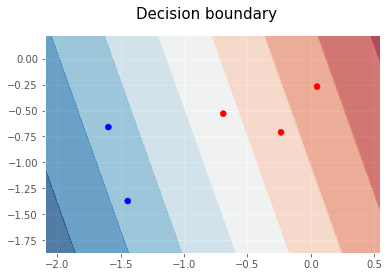

In [38]:
h = .02
x_min, x_max = X_train_feats[:, 6].min() - .5, X_train_feats[:, 6].max() + .5
y_min, y_max = X_train_feats[:, 7].min() - .5, X_train_feats[:, 7].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

cm = plt.cm.RdBu

Z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=cm, alpha=.7)
plt.scatter(X_train_feats[:, 6], X_train_feats[:, 7], c=y_train, cmap=cm_bright)
plt.suptitle("Decision boundary", fontsize=15)


### Testing

In [39]:
score = clf.score(X_test, y_test)
print("Classification accuracy: %.2f" % score)

Classification accuracy: 0.60
